In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
 
config = tf.ConfigProto()
# 指定可见显卡
# config.gpu_options.visible_device_list="1"
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
#不满显存, 自适应分配
config.gpu_options.allow_growth=True   
sess = tf.Session(config=config)
KTF.set_session(sess)

Using TensorFlow backend.


In [2]:
# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function

import numpy as np
import warnings
import tensorflow

%env KERAS_BACKEND=tensorflow
from keras.callbacks import LearningRateScheduler
import keras
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs


def identity_block_preactive(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
  
    x = BatchNormalization(axis=bn_axis)(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters1, (3, 3),
               kernel_initializer="he_normal",
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, (3,3),
               padding='same',
               kernel_initializer="he_normal",
               kernel_regularizer=l2(0.0001))(x)

    x = layers.add([x, input_tensor])

    return x

def conv_block_preactive(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    x = Conv2D(filters1, (3, 3), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, (3,3), padding='same',
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(x)


    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    return x


def identity_block_bottleneck(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
  

    x = Conv2D(filters1, (1, 1),
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               kernel_initializer="he_normal",
               kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block_bottleneck(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    x = Conv2D(filters1, (1, 1), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization(axis=bn_axis)(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50_cifar_small(input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):

    # Determine proper input shape
    input_shape = (48,42,3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((1, 1))(img_input)
    x = Conv2D(16, (3, 3), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    
    block_shape = K.int_shape(x)
    print(block_shape)
    
    x = conv_block_bottleneck(x, 3, [16, 16, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block_bottleneck(x, 3, [16, 16, 64], stage=2, block='b')
    x = identity_block_bottleneck(x, 3, [16, 16, 64], stage=2, block='c')
    
    block_shape = K.int_shape(x)
    print(block_shape)
    
    x = conv_block_bottleneck(x, 3, [32, 32, 128], stage=3, block='a')
    x = identity_block_bottleneck(x, 3, [32, 32, 128], stage=3, block='b')
    x = identity_block_bottleneck(x, 3, [32, 32, 128], stage=3, block='c')
    
    block_shape = K.int_shape(x)
    print(block_shape)
    
    x = conv_block_bottleneck(x, 3, [64, 64, 256], stage=4, block='a')
    x = identity_block_bottleneck(x, 3, [64, 64, 256], stage=4, block='b')
    x = identity_block_bottleneck(x, 3, [64, 64, 256], stage=4, block='c')
    
    
    block_shape = K.int_shape(x)
    print(block_shape)

    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]),strides=(1, 1))(x)

   
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model



   

env: KERAS_BACKEND=tensorflow


In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mean_image = np.mean(x_train, axis=0)
x_train -= mean_image
x_test -= mean_image
x_train = x_train/128
x_test = x_test/128 
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
def split_dataset(datapath, p):
    sample_folder_list = os.listdir(datapath) ##各个样本的文件夹
    sample_folder_list_dict = {} ##各个文件夹下的图片路径信息
    train_dir_dict = {} ##用作训练的样本路径集合
    test_dir_dict = {}##用作测试的样本路径集合

    for folder in sample_folder_list:
        sample_folder_list_dict[folder] = os.listdir(datapath+folder)
        train_dir_dict[folder] = random.sample(sample_folder_list_dict[folder], p)
        test_dir_dict[folder] = list(set(sample_folder_list_dict[folder])-set(train_dir_dict[folder]))

    train_label = []
    train_data = []

    test_label = []
    test_data = []

    for key in train_dir_dict:
        for path in train_dir_dict[key]:
            train_label.append(min(int(key[-2:])-1, 37))
            img = cv2.imread(datapath+key+'/'+path)
            img = cv2.resize(img, (42, 48))
            train_data.append(img)
        
        for path in test_dir_dict[key]:
            test_label.append(min(int(key[-2:])-1, 37))
            img = cv2.imread(datapath+key+'/'+path)
            img = cv2.resize(img, (42, 48))
            test_data.append(img)

    return train_data, train_label, test_data, test_label

In [16]:
import random
import cv2
datapath = '/root/zhb/Documents/PR/data/' 
train_data, train_label, test_data, test_label = split_dataset(datapath, 30)
train_data = np.asarray(train_data) / 255 - 0.5
train_label = np.asarray(train_label) 
test_data = np.asarray(test_data) / 255 - 0.5
test_label = np.asarray(test_label)
train_label = keras.utils.to_categorical(train_label, 38)
test_label = keras.utils.to_categorical(test_label, 38)

In [17]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.regularizers import l2

batch_size = 64
nb_classes = 38
nb_epoch = 1000
data_augmentation = True
lr_schedule = [40,60,70] # epoch_step
def schedule(epoch_idx):
    if (epoch_idx + 1) < lr_schedule[0]:
        return 0.001 
    if (epoch_idx + 1) < lr_schedule[1]:
        return 0.0001
    if (epoch_idx + 1) < lr_schedule[2]:
        return 0.001
    return 0.0001
  
   


model2 = ResNet50_cifar_small(classes = nb_classes)
    
model2.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_data)

# Fit the model on the batches generated by datagen.flow().
history = model2.fit_generator(datagen.flow(train_data, train_label, batch_size=batch_size),
                    steps_per_epoch=train_data.shape[0] // batch_size,
                    validation_data=(test_data, test_label) ,
                    epochs=nb_epoch, verbose=1, max_q_size=100,
                    callbacks=[ LearningRateScheduler(schedule=schedule)])

(None, 24, 21, 16)
(None, 24, 21, 64)
(None, 12, 11, 128)
(None, 6, 6, 256)


/root/zhb/conda/Anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=17, validation_data=(array([[[..., epochs=1000, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`


Epoch 1/1000
17/17 [==============================] - 18s 1s/step - loss: 4.0917 - acc: 0.0515 - val_loss: 4.6570 - val_acc: 0.0361
Epoch 2/1000
17/17 [==============================] - 2s 118ms/step - loss: 3.9148 - acc: 0.0539 - val_loss: 5.5584 - val_acc: 0.0353
Epoch 3/1000
17/17 [==============================] - 2s 112ms/step - loss: 3.7863 - acc: 0.0895 - val_loss: 5.1273 - val_acc: 0.0541
Epoch 4/1000
17/17 [==============================] - 2s 112ms/step - loss: 3.7689 - acc: 0.0806 - val_loss: 4.3040 - val_acc: 0.0481
Epoch 5/1000
17/17 [==============================] - 2s 109ms/step - loss: 3.6892 - acc: 0.1022 - val_loss: 5.5044 - val_acc: 0.0541
Epoch 6/1000
17/17 [==============================] - 2s 107ms/step - loss: 3.6332 - acc: 0.1121 - val_loss: 6.2167 - val_acc: 0.0414
Epoch 7/1000
17/17 [==============================] - 2s 106ms/step - loss: 3.5792 - acc: 0.1094 - val_loss: 11.9842 - val_acc: 0.0421
Epoch 8/1000
17/17 [==============================] - 2s 109ms/

Epoch 62/1000
17/17 [==============================] - 2s 115ms/step - loss: 1.2655 - acc: 0.7304 - val_loss: 4.1699 - val_acc: 0.2947
Epoch 63/1000
17/17 [==============================] - 2s 113ms/step - loss: 1.2006 - acc: 0.7303 - val_loss: 7.0708 - val_acc: 0.2038
Epoch 64/1000
17/17 [==============================] - 2s 107ms/step - loss: 1.2014 - acc: 0.7288 - val_loss: 4.3060 - val_acc: 0.3045
Epoch 65/1000
17/17 [==============================] - 2s 114ms/step - loss: 1.1877 - acc: 0.7346 - val_loss: 3.9608 - val_acc: 0.3308
Epoch 66/1000
17/17 [==============================] - 2s 107ms/step - loss: 1.0879 - acc: 0.7579 - val_loss: 3.2462 - val_acc: 0.3744
Epoch 67/1000
17/17 [==============================] - 2s 106ms/step - loss: 1.0563 - acc: 0.7879 - val_loss: 2.9787 - val_acc: 0.4060
Epoch 68/1000
17/17 [==============================] - 2s 110ms/step - loss: 1.0083 - acc: 0.8091 - val_loss: 5.3494 - val_acc: 0.3827
Epoch 69/1000
17/17 [==============================] - 

17/17 [==============================] - 2s 106ms/step - loss: 0.4881 - acc: 0.9721 - val_loss: 0.9478 - val_acc: 0.8436
Epoch 183/1000
17/17 [==============================] - 2s 109ms/step - loss: 0.4966 - acc: 0.9649 - val_loss: 0.9326 - val_acc: 0.8534
Epoch 184/1000
17/17 [==============================] - 2s 110ms/step - loss: 0.4807 - acc: 0.9716 - val_loss: 0.9157 - val_acc: 0.8586
Epoch 185/1000
17/17 [==============================] - 2s 110ms/step - loss: 0.4848 - acc: 0.9702 - val_loss: 0.9318 - val_acc: 0.8459
Epoch 186/1000
17/17 [==============================] - 2s 108ms/step - loss: 0.4771 - acc: 0.9773 - val_loss: 0.9068 - val_acc: 0.8624
Epoch 187/1000
17/17 [==============================] - 2s 113ms/step - loss: 0.4976 - acc: 0.9630 - val_loss: 0.9493 - val_acc: 0.8556
Epoch 188/1000
17/17 [==============================] - 2s 115ms/step - loss: 0.4989 - acc: 0.9601 - val_loss: 0.9188 - val_acc: 0.8564
Epoch 189/1000
17/17 [==============================] - 2s 106m

17/17 [==============================] - 1s 67ms/step - loss: 0.4069 - acc: 0.9828 - val_loss: 0.9970 - val_acc: 0.8564
Epoch 303/1000
17/17 [==============================] - 1s 69ms/step - loss: 0.4113 - acc: 0.9768 - val_loss: 1.1613 - val_acc: 0.8226
Epoch 304/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3992 - acc: 0.9847 - val_loss: 0.9236 - val_acc: 0.8714
Epoch 305/1000
17/17 [==============================] - 1s 67ms/step - loss: 0.4015 - acc: 0.9871 - val_loss: 1.0395 - val_acc: 0.8526
Epoch 306/1000
17/17 [==============================] - 1s 69ms/step - loss: 0.4083 - acc: 0.9807 - val_loss: 0.9492 - val_acc: 0.8609
Epoch 307/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3955 - acc: 0.9899 - val_loss: 0.9272 - val_acc: 0.8632
Epoch 308/1000
17/17 [==============================] - 1s 72ms/step - loss: 0.3986 - acc: 0.9862 - val_loss: 1.2476 - val_acc: 0.7985
Epoch 309/1000
17/17 [==============================] - 1s 63ms/step -

Epoch 363/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3712 - acc: 0.9917 - val_loss: 0.9969 - val_acc: 0.8684
Epoch 364/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.3806 - acc: 0.9888 - val_loss: 0.9848 - val_acc: 0.8451
Epoch 365/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.3824 - acc: 0.9899 - val_loss: 0.9950 - val_acc: 0.8496
Epoch 366/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3809 - acc: 0.9904 - val_loss: 0.8601 - val_acc: 0.8962
Epoch 367/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3761 - acc: 0.9915 - val_loss: 0.8593 - val_acc: 0.8902
Epoch 368/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.3729 - acc: 0.9888 - val_loss: 0.8296 - val_acc: 0.8970
Epoch 369/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.3736 - acc: 0.9917 - val_loss: 0.8568 - val_acc: 0.8895
Epoch 370/1000
17/17 [==============================] -

Epoch 424/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.3544 - acc: 0.9952 - val_loss: 0.8400 - val_acc: 0.8992
Epoch 425/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3608 - acc: 0.9908 - val_loss: 0.8700 - val_acc: 0.8850
Epoch 426/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3828 - acc: 0.9842 - val_loss: 0.9188 - val_acc: 0.8850
Epoch 427/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3734 - acc: 0.9888 - val_loss: 1.4757 - val_acc: 0.7955
Epoch 428/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3671 - acc: 0.9897 - val_loss: 0.9275 - val_acc: 0.8782
Epoch 429/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.3606 - acc: 0.9917 - val_loss: 1.0004 - val_acc: 0.8699
Epoch 430/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.3526 - acc: 0.9950 - val_loss: 0.8403 - val_acc: 0.8977
Epoch 431/1000
17/17 [==============================] -

Epoch 485/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.3400 - acc: 0.9982 - val_loss: 0.8539 - val_acc: 0.9008
Epoch 486/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3460 - acc: 0.9972 - val_loss: 0.8581 - val_acc: 0.9000
Epoch 487/1000
17/17 [==============================] - 1s 59ms/step - loss: 0.3483 - acc: 0.9917 - val_loss: 0.9794 - val_acc: 0.8737
Epoch 488/1000
17/17 [==============================] - 1s 67ms/step - loss: 0.3416 - acc: 0.9954 - val_loss: 0.8730 - val_acc: 0.8962
Epoch 489/1000
17/17 [==============================] - 1s 80ms/step - loss: 0.3510 - acc: 0.9936 - val_loss: 0.8722 - val_acc: 0.8947
Epoch 490/1000
17/17 [==============================] - 1s 76ms/step - loss: 0.3481 - acc: 0.9908 - val_loss: 0.9767 - val_acc: 0.8534
Epoch 491/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3509 - acc: 0.9926 - val_loss: 0.8514 - val_acc: 0.8902
Epoch 492/1000
17/17 [==============================] -

Epoch 546/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3396 - acc: 0.9936 - val_loss: 0.9707 - val_acc: 0.8714
Epoch 547/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.3375 - acc: 0.9963 - val_loss: 0.8062 - val_acc: 0.9060
Epoch 548/1000
17/17 [==============================] - 1s 59ms/step - loss: 0.3318 - acc: 0.9954 - val_loss: 0.9901 - val_acc: 0.8699
Epoch 549/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3299 - acc: 0.9982 - val_loss: 0.9673 - val_acc: 0.8714
Epoch 550/1000
17/17 [==============================] - 1s 67ms/step - loss: 0.3373 - acc: 0.9915 - val_loss: 0.8262 - val_acc: 0.9105
Epoch 551/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.3375 - acc: 0.9936 - val_loss: 0.8530 - val_acc: 0.8835
Epoch 552/1000
17/17 [==============================] - 1s 60ms/step - loss: 0.3407 - acc: 0.9932 - val_loss: 1.0444 - val_acc: 0.8398
Epoch 553/1000
17/17 [==============================] -

Epoch 607/1000
17/17 [==============================] - 1s 68ms/step - loss: 0.3343 - acc: 0.9926 - val_loss: 1.0231 - val_acc: 0.8692
Epoch 608/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.3438 - acc: 0.9867 - val_loss: 0.9434 - val_acc: 0.8707
Epoch 609/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3258 - acc: 0.9954 - val_loss: 0.8705 - val_acc: 0.8880
Epoch 610/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3275 - acc: 0.9963 - val_loss: 0.8555 - val_acc: 0.8902
Epoch 611/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3207 - acc: 0.9991 - val_loss: 0.8507 - val_acc: 0.8985
Epoch 612/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3231 - acc: 0.9982 - val_loss: 0.8147 - val_acc: 0.9135
Epoch 613/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.3265 - acc: 0.9982 - val_loss: 0.7904 - val_acc: 0.9135
Epoch 614/1000
17/17 [==============================] -

Epoch 668/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.3125 - acc: 0.9982 - val_loss: 1.1199 - val_acc: 0.8383
Epoch 669/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.3125 - acc: 0.9972 - val_loss: 1.0583 - val_acc: 0.8429
Epoch 670/1000
17/17 [==============================] - 1s 60ms/step - loss: 0.3128 - acc: 0.9972 - val_loss: 1.0195 - val_acc: 0.8549
Epoch 671/1000
17/17 [==============================] - 1s 67ms/step - loss: 0.3136 - acc: 0.9972 - val_loss: 0.8466 - val_acc: 0.8917
Epoch 672/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3117 - acc: 0.9954 - val_loss: 0.8244 - val_acc: 0.9030
Epoch 673/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.3179 - acc: 0.9945 - val_loss: 0.8484 - val_acc: 0.8917
Epoch 674/1000
17/17 [==============================] - 1s 60ms/step - loss: 0.3156 - acc: 0.9982 - val_loss: 1.1195 - val_acc: 0.8353
Epoch 675/1000
17/17 [==============================] -

Epoch 729/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.3222 - acc: 0.9906 - val_loss: 0.9776 - val_acc: 0.8669
Epoch 730/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.3123 - acc: 0.9908 - val_loss: 1.0449 - val_acc: 0.8534
Epoch 731/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.3149 - acc: 0.9936 - val_loss: 0.9567 - val_acc: 0.8654
Epoch 732/1000
17/17 [==============================] - 1s 59ms/step - loss: 0.3106 - acc: 0.9954 - val_loss: 0.8794 - val_acc: 0.8789
Epoch 733/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3102 - acc: 0.9963 - val_loss: 0.8477 - val_acc: 0.8970
Epoch 734/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3102 - acc: 0.9945 - val_loss: 0.8244 - val_acc: 0.9030
Epoch 735/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.3100 - acc: 0.9943 - val_loss: 0.7724 - val_acc: 0.9143
Epoch 736/1000
17/17 [==============================] -

Epoch 790/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3003 - acc: 0.9972 - val_loss: 0.8252 - val_acc: 0.9075
Epoch 791/1000
17/17 [==============================] - 1s 60ms/step - loss: 0.3025 - acc: 0.9943 - val_loss: 0.8577 - val_acc: 0.9098
Epoch 792/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.3132 - acc: 0.9963 - val_loss: 1.1779 - val_acc: 0.8346
Epoch 793/1000
17/17 [==============================] - 1s 74ms/step - loss: 0.3024 - acc: 0.9954 - val_loss: 0.8794 - val_acc: 0.8992
Epoch 794/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.3011 - acc: 0.9980 - val_loss: 1.1928 - val_acc: 0.8323
Epoch 795/1000
17/17 [==============================] - 1s 62ms/step - loss: 0.3062 - acc: 0.9936 - val_loss: 0.8398 - val_acc: 0.9008
Epoch 796/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.2998 - acc: 0.9954 - val_loss: 0.8917 - val_acc: 0.8977
Epoch 797/1000
17/17 [==============================] -

Epoch 851/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.2915 - acc: 0.9972 - val_loss: 0.8097 - val_acc: 0.9113
Epoch 852/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.2955 - acc: 0.9945 - val_loss: 0.7876 - val_acc: 0.9180
Epoch 853/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.2886 - acc: 0.9991 - val_loss: 0.7817 - val_acc: 0.9158
Epoch 854/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.2883 - acc: 0.9972 - val_loss: 0.8096 - val_acc: 0.9053
Epoch 855/1000
17/17 [==============================] - 1s 68ms/step - loss: 0.2854 - acc: 0.9982 - val_loss: 0.8608 - val_acc: 0.8895
Epoch 856/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.2916 - acc: 0.9954 - val_loss: 0.8986 - val_acc: 0.8812
Epoch 857/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.2867 - acc: 0.9982 - val_loss: 0.8250 - val_acc: 0.8977
Epoch 858/1000
17/17 [==============================] -

Epoch 912/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.2821 - acc: 0.9991 - val_loss: 0.7848 - val_acc: 0.9120
Epoch 913/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.2844 - acc: 0.9963 - val_loss: 0.7663 - val_acc: 0.9211
Epoch 914/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.2845 - acc: 0.9963 - val_loss: 0.8421 - val_acc: 0.8857
Epoch 915/1000
17/17 [==============================] - 1s 65ms/step - loss: 0.2883 - acc: 0.9936 - val_loss: 0.7695 - val_acc: 0.9195
Epoch 916/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.2829 - acc: 0.9982 - val_loss: 0.9455 - val_acc: 0.8850
Epoch 917/1000
17/17 [==============================] - 1s 64ms/step - loss: 0.2874 - acc: 0.9972 - val_loss: 0.9812 - val_acc: 0.8654
Epoch 918/1000
17/17 [==============================] - 1s 61ms/step - loss: 0.2901 - acc: 0.9943 - val_loss: 0.8402 - val_acc: 0.8962
Epoch 919/1000
17/17 [==============================] -

Epoch 973/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.2713 - acc: 1.0000 - val_loss: 0.8572 - val_acc: 0.9053
Epoch 974/1000
17/17 [==============================] - 1s 67ms/step - loss: 0.2722 - acc: 1.0000 - val_loss: 0.7988 - val_acc: 0.9158
Epoch 975/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.2698 - acc: 1.0000 - val_loss: 0.7625 - val_acc: 0.9241
Epoch 976/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.2729 - acc: 0.9982 - val_loss: 0.8894 - val_acc: 0.8925
Epoch 977/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.2762 - acc: 0.9982 - val_loss: 0.7777 - val_acc: 0.9128
Epoch 978/1000
17/17 [==============================] - 1s 63ms/step - loss: 0.2712 - acc: 0.9982 - val_loss: 0.7672 - val_acc: 0.9150
Epoch 979/1000
17/17 [==============================] - 1s 66ms/step - loss: 0.2718 - acc: 1.0000 - val_loss: 0.7545 - val_acc: 0.9128
Epoch 980/1000
17/17 [==============================] -

In [6]:
model2.save('resnet50_s_cifar10.h5')


In [1]:
print(history.history.keys())


NameError: name 'history' is not defined

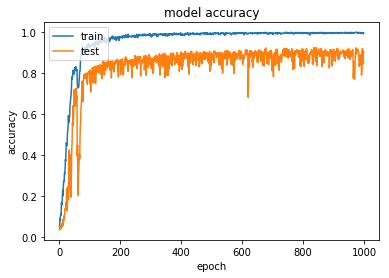

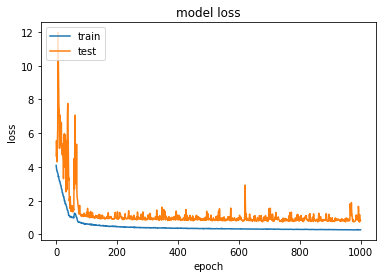

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
n = 10000
y_pred = model2.predict(x_test[:n])
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test[:n], axis=1))
print("Accuracy on first %i benign test samples: %f" % (n, accuracy))

Accuracy on first 10000 benign test samples: 0.858900
